In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model
from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
import simtrain.utils as utils
from simtrain.Dataset import CustomDataset
from simtrain.train import train

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup


In [3]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 50 # make data smaller
experiment_name = "testing2"

In [4]:
#create dataset from processed data
'''
train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

print(stg)

def convert_string_to_double_list(s):
    return ast.literal_eval(s)

# Apply the custom function
train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

print("len: ", len(train_dat))
list_of_dicts = train_dat.to_dict(orient='records')
list_of_dicts = list_of_dicts[:subset]
train_dat.head()
'''

'\ntrain_dat, stg = process_dat.load_dat(paths.cw_stages[\'output_new\'][\'train\'], new_data=True)\n\nprint(stg)\n\ndef convert_string_to_double_list(s):\n    return ast.literal_eval(s)\n\n# Apply the custom function\ntrain_dat[\'item_ids\'] = train_dat[\'item_ids\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_means\'] = train_dat[\'user_means\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_vars_log\'] = train_dat[\'user_vars_log\'].apply(convert_string_to_double_list)\ntrain_dat[\'timestamps\'] = train_dat[\'timestamps\'].apply(convert_string_to_double_list)\ntrain_dat[\'interaction_types\'] = train_dat[\'interaction_types\'].apply(convert_string_to_double_list)\n\nprint("len: ", len(train_dat))\nlist_of_dicts = train_dat.to_dict(orient=\'records\')\nlist_of_dicts = list_of_dicts[:subset]\ntrain_dat.head()\n'

In [5]:

checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5"))
list_of_dicts = checkpoint['data']

In [6]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''

'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [7]:

dataset = CustomDataset(list_of_dicts) # [:50]
# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [8]:
def test_timestamps(dataloader):
    smallest = float("inf")
    biggest = -1
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
    print(smallest), print(biggest)
    return biggest

max_time = test_timestamps(dataloader)

tensor([0.0417], dtype=torch.float64)
tensor([69.3333], dtype=torch.float64)


In [9]:
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    

Timestamps: [tensor([5.], dtype=torch.float64), tensor([5.0417], dtype=torch.float64), tensor([5.0833], dtype=torch.float64), tensor([41.0833], dtype=torch.float64)]
item_recom: [[tensor([53]), tensor([50]), tensor([217]), tensor([205]), tensor([66]), tensor([53]), tensor([199]), tensor([134]), tensor([2]), tensor([53]), tensor([66]), tensor([50]), tensor([199]), tensor([77]), tensor([134]), tensor([77]), tensor([2]), tensor([134]), tensor([77]), tensor([50]), tensor([66]), tensor([199]), tensor([217]), tensor([205]), tensor([205]), tensor([217]), tensor([2])], [tensor([168]), tensor([205]), tensor([217]), tensor([138]), tensor([53]), tensor([166]), tensor([203]), tensor([73]), tensor([138]), tensor([168]), tensor([159]), tensor([66]), tensor([268]), tensor([297]), tensor([66]), tensor([261]), tensor([178]), tensor([159]), tensor([178]), tensor([203]), tensor([203]), tensor([159]), tensor([168]), tensor([138]), tensor([217]), tensor([205]), tensor([53]), tensor([57]), tensor([297]), te

In [10]:
# parameter dicts
width= 10
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width, 3],
                                                         "noise": 0},
                                          "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [11]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
                            "jump_model": jump_state_dict}
model = User_simmulation_Model(hyperparameter_dict)

In [12]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [13]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-8)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [14]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0223], dtype=torch.float64), tensor([-0.0950], dtype=torch.float64), tensor([0.0211], dtype=torch.float64)]
logvar:  [tensor([-0.1155], dtype=torch.float64), tensor([-0.1155], dtype=torch.float64), tensor([-0.1155], dtype=torch.float64)]
means:  [tensor([2.3246e-05], dtype=torch.float64), tensor([0.0005], dtype=torch.float64), tensor([3.8117e-05], dtype=torch.float64)]
logvar:  [tensor([-0.1211], dtype=torch.float64), tensor([0.0036], dtype=torch.float64), tensor([-0.0649], dtype=torch.float64)]
means:  [tensor([0.0006], dtype=torch.float64), tensor([-0.0007], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.1155], dtype=torch.float64), tensor([-0.1155], dtype=torch.float64), tensor([-0.1155], dtype=torch.float64)]
means:  [tensor([0.0003], dtype=torch.float64), tensor([-0.0004], dtype=torch.float64), tensor([-1.4478e-05], dtype=torch.float64)]
logvar:  [tensor([-0.1155], dtype=torch.float64), tensor([-0.1155], dtype=torch.float64), 

In [15]:
train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=1., user_lr=0.1,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func,warmup_period=warmup_period, intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = nn.functional.log_softmax(y_pred)
 10%|█         | 1/10 [14:32<2:10:51, 872.37s/it]

loss_all: inf 	loss_base: 186.50 	loss_kl: 596446.69 	loss_intensity:  inf 	log of the loss: inf


 10%|█         | 1/10 [15:29<2:19:28, 929.82s/it]


KeyboardInterrupt: 

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0149], dtype=torch.float64), tensor([-0.0143], dtype=torch.float64), tensor([0.0468], dtype=torch.float64), tensor([0.0425], dtype=torch.float64), tensor([0.0993], dtype=torch.float64), tensor([0.0387], dtype=torch.float64), tensor([-0.0228], dtype=torch.float64), tensor([-0.0680], dtype=torch.float64)]
logvar:  [tensor([0.1817], dtype=torch.float64), tensor([-0.0555], dtype=torch.float64), tensor([-0.0278], dtype=torch.float64), tensor([-0.3957], dtype=torch.float64), tensor([0.0319], dtype=torch.float64), tensor([-0.1186], dtype=torch.float64), tensor([0.1501], dtype=torch.float64), tensor([0.3147], dtype=torch.float64)]
means:  [tensor([0.0865], dtype=torch.float64), tensor([-0.1777], dtype=torch.float64), tensor([0.0748], dtype=torch.float64), tensor([-0.1917], dtype=torch.float64), tensor([-0.0618], dtype=torch.float64), tensor([0.0318], dtype=torch.float64), tensor([0.0258], dtype=torch.float64), tensor([0.0558], dtype=torch.float64)]
logvar:  [tensor([0.0162],

In [13]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [14]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.
overall_intensity:  tensor([[0.0047]]) 	user_intensity:  tensor([[0.]]) 	global_intensity:  tensor([0.0047]) 	 before a recommendation.


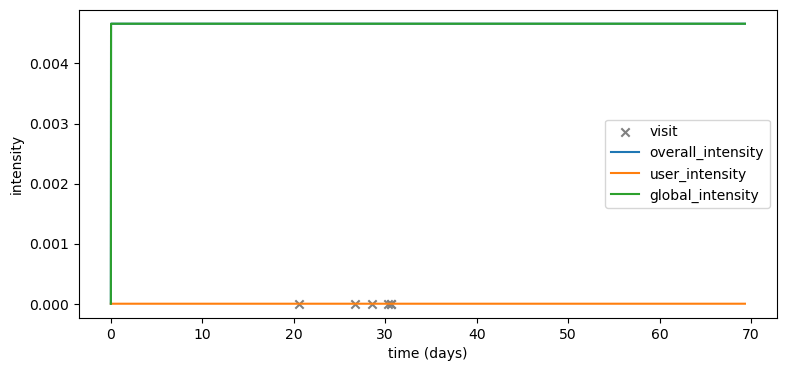

In [15]:
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)